In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
import pandas as pd

dev_data = pd.read_csv('/content/drive/MyDrive/Convolve/Datasets/Dev_data_to_be_shared.csv')
valid_data = pd.read_csv('/content/drive/MyDrive/Convolve/Datasets/validation_data_to_be_shared.csv')

In [ ]:
!pip install -q imbalanced-learn xgboost lightgbm dask[dataframe]
!pip install -U xgboost
!pip install -U lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 14.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings

warnings.filterwarnings('ignore')

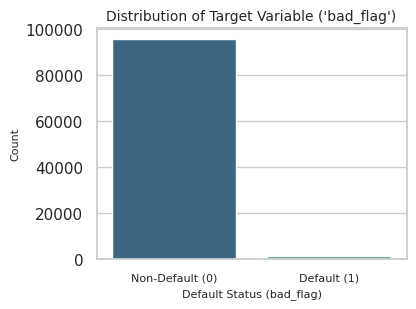

In [ ]:
sns.set(style="whitegrid")

# Step 1: Target Variable Analysis
plt.figure(figsize=(4, 3))
bad_flag_counts = dev_data['bad_flag'].value_counts()
sns.barplot(x=bad_flag_counts.index, y=bad_flag_counts.values, palette="viridis")
plt.title("Distribution of Target Variable ('bad_flag')", fontsize=10)
plt.xlabel("Default Status (bad_flag)", fontsize=8)
plt.ylabel("Count", fontsize=8)
plt.xticks([0, 1], ['Non-Default (0)', 'Default (1)'], fontsize=8)
plt.show()

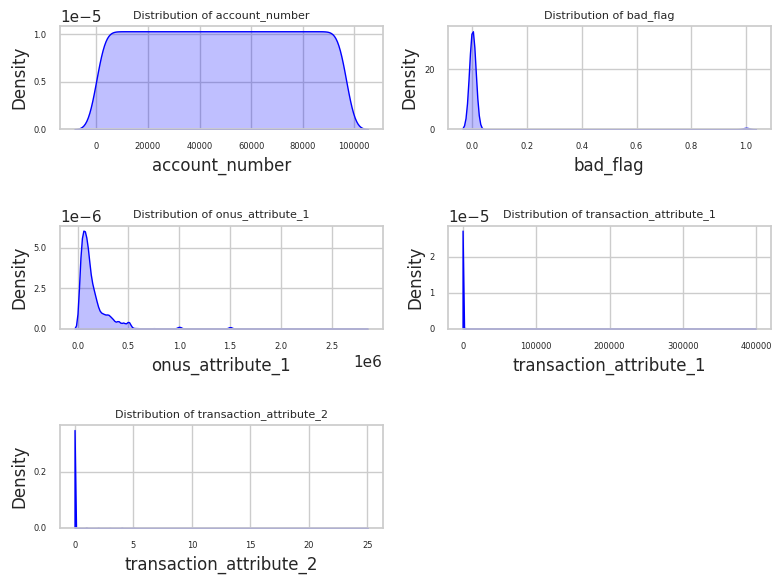

In [ ]:
dev_num_data = dev_data.select_dtypes(include=[np.number])
key_features = dev_num_data.columns[:5]  # Adjust the number of features as needed
plt.figure(figsize=(8, 6))
for i, col in enumerate(key_features, 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(dev_data[col], shade=True, color="blue")
    plt.title(f"Distribution of {col}", fontsize=8)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()

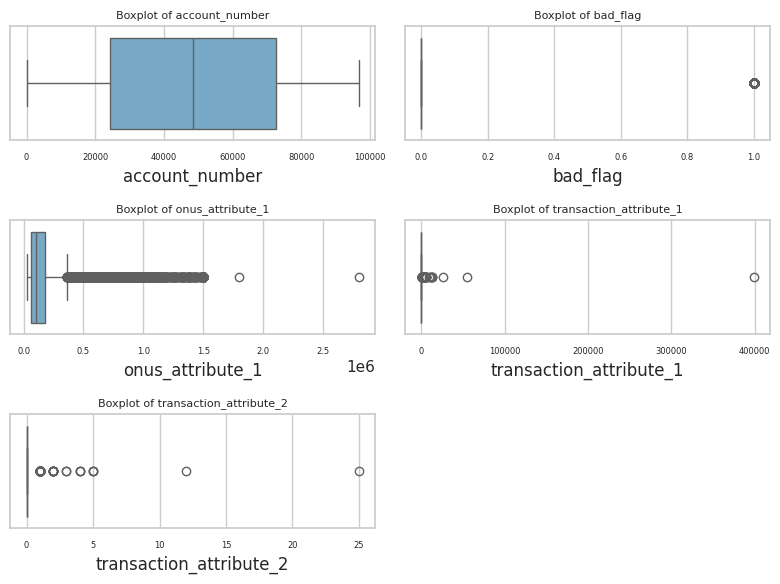

In [ ]:
plt.figure(figsize=(8, 6))
for i, col in enumerate(key_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=dev_data[col], palette="Blues")
    plt.title(f"Boxplot of {col}", fontsize=8)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()

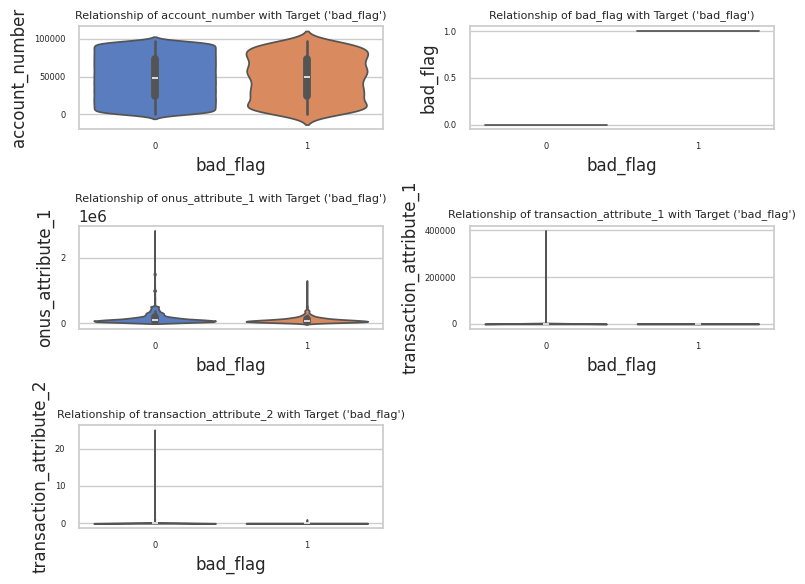

In [ ]:
plt.figure(figsize=(8, 6))
for i, col in enumerate(key_features, 1):
    plt.subplot(3, 2, i)
    sns.violinplot(x='bad_flag', y=col, data=dev_data, palette="muted")
    plt.title(f"Relationship of {col} with Target ('bad_flag')", fontsize=8)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()

In [ ]:
# Data Preprocessing
# Drop columns with high missing values or irrelevant data
missing_threshold = 0.4
drop_cols = dev_data.columns[dev_data.isnull().mean() > missing_threshold]
dev_data.drop(columns=drop_cols, inplace=True)
valid_data.drop(columns=drop_cols, inplace=True)

for col in dev_data.columns:
    if dev_data[col].dtype == 'object':
        dev_data[col] = dev_data[col].fillna(dev_data[col].mode()[0])
    else:
        dev_data[col] = dev_data[col].fillna(dev_data[col].median())
for col in valid_data.columns:
    if valid_data[col].dtype == 'object':
        valid_data[col] = valid_data[col].fillna(valid_data[col].mode()[0])
    else:
        valid_data[col] = valid_data[col].fillna(valid_data[col].median())

In [ ]:
# 4. Feature Engineering
X = dev_data.drop(columns=['bad_flag', 'account_number'])
y = dev_data['bad_flag']
X_val = valid_data.drop(columns=['account_number'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_val_scaled = scaler.transform(X_val)

# Dimensionality Reduction with PCA
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Handle Class Imbalance with Optimized SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)
X_res, y_res = smote.fit_resample(X_pca, y)



In [ ]:
#Hyperparameter Tuning with RandomizedSearchCV for LightGBM
param_dist = {
       'max_depth': [5, 7, 9],
       'learning_rate': [0.05, 0.1],
       'n_estimators': [300, 500],
       'subsample': [0.8, 1.0],
       'colsample_bytree': [0.8, 1.0]
   }

lgbm_model = LGBMClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=lgbm_model, param_distributions=param_dist, n_iter=10,
                                   scoring='roc_auc', cv=2, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_res, y_res)

best_model = random_search.best_estimator_

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 95434, number of negative: 95434
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.117513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102000
[LightGBM] [Info] Number of data points in the train set: 190868, number of used features: 400
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LightGBM AUC Score after Tuning: 0.9999


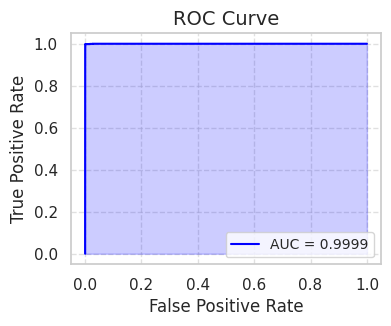

Optimal Threshold: 0.6482
Classification Report at Optimal Threshold:

              precision    recall  f1-score   support

 Non-Default       1.00      1.00      1.00     95434
     Default       0.93      1.00      0.96      1372

    accuracy                           1.00     96806
   macro avg       0.97      1.00      0.98     96806
weighted avg       1.00      1.00      1.00     96806



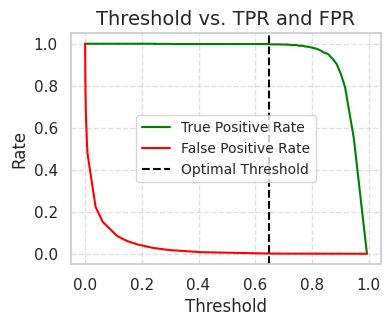

In [13]:
# Evaluation on Development Data
y_pred_prob = best_model.predict_proba(X_pca)[:, 1]
auc_score = roc_auc_score(y, y_pred_prob)
print(f'LightGBM AUC Score after Tuning: {auc_score:.4f}')

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.4f}')
plt.fill_between(fpr, 0, tpr, color='blue', alpha=0.2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Display Additional Metrics
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal Threshold: {optimal_threshold:.4f}')

# Classification Report at Optimal Threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)
report = classification_report(y, y_pred_optimal, target_names=['Non-Default', 'Default'])
print("Classification Report at Optimal Threshold:\n")
print(report)

# Visualize Threshold vs. TPR and FPR
plt.figure(figsize=(4, 3))
plt.plot(thresholds, tpr, label='True Positive Rate', color='green')
plt.plot(thresholds, fpr, label='False Positive Rate', color='red')
plt.axvline(optimal_threshold, color='black', linestyle='--', label='Optimal Threshold')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Rate', fontsize=12)
plt.title('Threshold vs. TPR and FPR', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [14]:
val_pred_prob = best_model.predict_proba(X_val_pca)[:, 1]

In [15]:
submission = pd.DataFrame({
    'account_number': valid_data['account_number'],
    'default_probability': val_pred_prob
})
submission.to_csv('/content/validation_predictions.csv', index=False)
print('Submission file saved as validation_predictions.csv')


Submission file saved as validation_predictions.csv


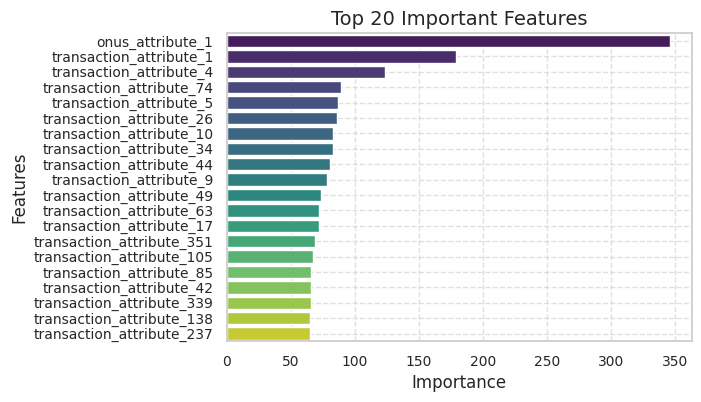

Top 10 Features by Importance:

1. onus_attribute_1: 346.0000
2. transaction_attribute_1: 179.0000
3. transaction_attribute_4: 124.0000
4. transaction_attribute_74: 89.0000
5. transaction_attribute_5: 87.0000
6. transaction_attribute_26: 86.0000
7. transaction_attribute_10: 83.0000
8. transaction_attribute_34: 83.0000
9. transaction_attribute_44: 81.0000
10. transaction_attribute_9: 78.0000


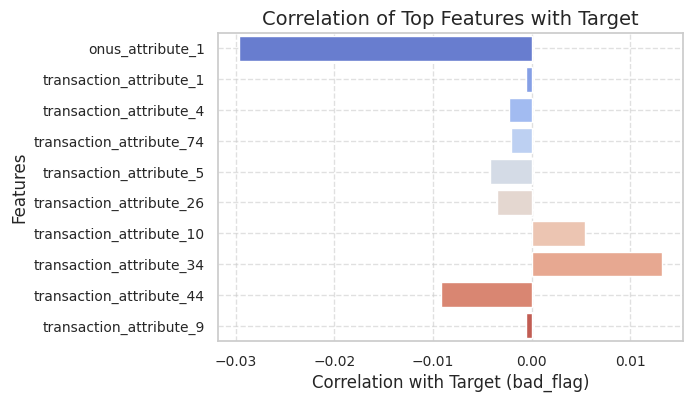

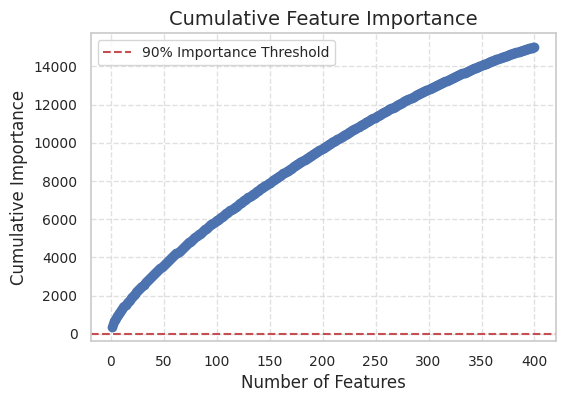

Number of features contributing to 90% of total importance: 0


In [16]:
# Key Insights: Feature Importance
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns[:len(best_model.feature_importances_)]).sort_values(ascending=False)
plt.figure(figsize=(6, 4))

# Top 20 Feature Importances
sns.barplot(x=feature_importances[:20], y=feature_importances.index[:20], palette='viridis')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 20 Important Features', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Insights Table
print("Top 10 Features by Importance:\n")
for i, (feature, importance) in enumerate(feature_importances[:10].items(), 1):
    print(f"{i}. {feature}: {importance:.4f}")

# Correlation of Top Features with Target
plt.figure(figsize=(6, 4))
top_features = feature_importances.index[:10]
correlations = dev_data[top_features].corrwith(dev_data['bad_flag'])
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.xlabel('Correlation with Target (bad_flag)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Correlation of Top Features with Target', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Cumulative Feature Importance
cumulative_importances = feature_importances.cumsum()
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(cumulative_importances) + 1), cumulative_importances, marker='o', color='b')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Importance Threshold')
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Cumulative Importance', fontsize=12)
plt.title('Cumulative Feature Importance', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Features contributing to 90% importance
num_features_90 = cumulative_importances[cumulative_importances <= 0.9].count()
print(f"Number of features contributing to 90% of total importance: {num_features_90}")